In [1]:
import pyarrow # Please note that you need to install `pyarrow` (`pip install pyarrow`) to use Parquet IO functionalities.
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler

# Data Loading

In [2]:
df_train = pd.read_parquet("../data/3-recommendations_100000_samples-train_preprocessed.parquet")
df_train.shape

(80000, 471)

In [3]:
df_test = pd.read_parquet("../data/3-recommendations_100000_samples-test_preprocessed.parquet")
df_test.shape

(20000, 471)

In [4]:
# df_train.drop(columns=["funny", "user_reviews", "price_final", "price_original", "discount", "steam_deck"])
# df_test.drop(columns=["funny", "user_reviews", "price_final", "price_original", "discount", "steam_deck"])

In [5]:
# I conducted several experiments including:
# 1. Excluding all tag features and their dimension-reduced counterparts.
# 2. Using only the PCA columns of tag features.
# 3. Using only the t-SNE columns of tag features.
# 4. Using only the UMAP columns of tag features.
# There were almost no differences observed.
X_train = df_train[[
    c for c in df_train 
    if c != "is_recommended"
    and not c.startswith("tag_")
    and not c.startswith("PCA_")
    and not c.startswith("tSNE_")
    and not c.startswith("UMAP_")
]]
y_train = df_train["is_recommended"]
print(f"{X_train.shape=} {y_train.shape=}")
X_test = df_test[[
    c for c in df_test 
    if c != "is_recommended"
    and not c.startswith("tag_")
    and not c.startswith("PCA_")
    and not c.startswith("tSNE_")
    and not c.startswith("UMAP_")
]]
y_test = df_test["is_recommended"]
print(f"{X_test.shape=} {y_test.shape=}")

X_train.shape=(80000, 17) y_train.shape=(80000,)
X_test.shape=(20000, 17) y_test.shape=(20000,)


In [6]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression

In [7]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l1', 'l2'],  # l2
    'C': [0.0001, 0.0002, 0.0003, 0.0005, 0.0007, 0.001, 0.01, 0.1, 1, 10, 100],  # 0.0005
    'solver': ['liblinear', 'saga']  # saga
}

In [8]:
# Perform grid search with cross-validation to find the best parameters
log_reg = LogisticRegression(max_iter=10000)
grid_search = GridSearchCV(
    log_reg, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': [0.0001, 0.0002, 0.0003, 0.0005, 0.0007, 0.001,
                               0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [9]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 0.0005, 'penalty': 'l2', 'solver': 'saga'}


In [10]:
# Train the Logistic Regression classifier using the best parameters
best_log_reg = LogisticRegression(**best_params, max_iter=10000)
best_log_reg.fit(X_train, y_train)

LogisticRegression(C=0.0005, max_iter=10000, solver='saga')

## Evaluate the classifier using various metrics

In [11]:
def evaluate_model(model, X_test, y_test):
    evaluation_results = {}

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix: \n {conf_matrix}")
    evaluation_results["confusion_matrix"] = conf_matrix.tolist()
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    evaluation_results["accuracy"] = accuracy
    
    # Precision
    precision = precision_score(y_test, y_pred)
    print("Precision:", precision)
    evaluation_results["precision"] = precision
    
    # Recall
    recall = recall_score(y_test, y_pred)
    print("Recall:", recall)
    evaluation_results["recall"] = recall
    
    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)
    evaluation_results["f1_score"] = f1
    
    # ROC Curve and ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    roc_curve_data = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc_auc": roc_auc}
    evaluation_results["roc_curve"] = roc_curve_data
    
    # Precision-Recall Curve and Average Precision
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    average_precision = average_precision_score(y_test, y_proba)
    
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

    pr_curve = {"precision": precision.tolist(), "recall": recall.tolist(), "average_precision": average_precision}
    evaluation_results["precision_recall_curve"] = pr_curve

    return evaluation_results


Confusion Matrix: 
 [[  190  2812]
 [   99 16899]]
Accuracy: 0.85445
Precision: 0.8573385419309015
Recall: 0.9941757853865161
F1 Score: 0.9207006456182408


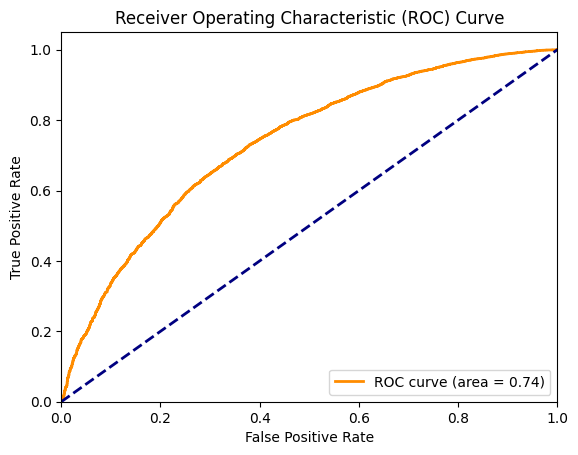

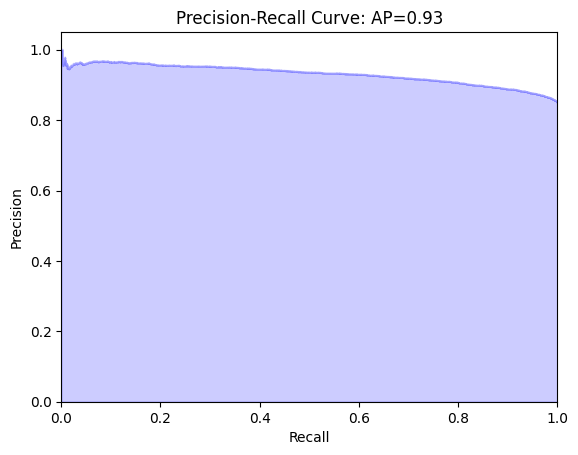

In [12]:
best_logistic_evaluation_results = evaluate_model(best_log_reg, X_test, y_test)

In [13]:
# Save results to a JSON file
with open("../data/5-best_logistic_evaluation_results.json", "w") as json_file:
    json.dump(best_logistic_evaluation_results, json_file, indent=4)

# Mean Cross-Validation Score for Different Parameter Settings

In [14]:
param_grid.items()

dict_items([('penalty', ['l1', 'l2']), ('C', [0.0001, 0.0002, 0.0003, 0.0005, 0.0007, 0.001, 0.01, 0.1, 1, 10, 100]), ('solver', ['liblinear', 'saga'])])

In [15]:
grid_search.cv_results_['mean_test_score']

array([0.859625 , 0.859625 , 0.8622875, 0.8615875, 0.8596375, 0.859625 ,
       0.8630375, 0.8628   , 0.861675 , 0.8612625, 0.86325  , 0.8631625,
       0.8631125, 0.8628375, 0.8634   , 0.863575 , 0.86315  , 0.8633125,
       0.863375 , 0.8634   , 0.8629375, 0.8631625, 0.8633125, 0.863575 ,
       0.8633625, 0.8633875, 0.863125 , 0.8631375, 0.8631375, 0.8631125,
       0.8630875, 0.8630875, 0.863075 , 0.863075 , 0.8630875, 0.8630875,
       0.8630875, 0.8630875, 0.8630875, 0.8630875, 0.8630875, 0.8630875,
       0.8630875, 0.8630875])

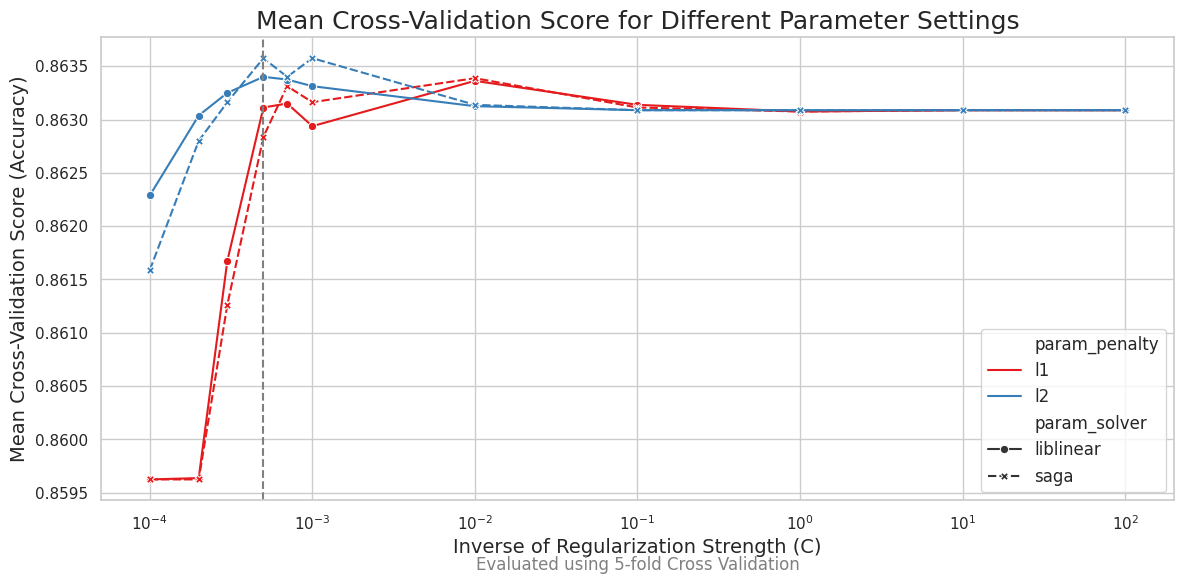

In [16]:
# Get the results of grid search
results = grid_search.cv_results_

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting the accuracy change for each parameter setting
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df, 
    x='param_C', 
    y='mean_test_score', 
    hue='param_penalty', 
    style='param_solver', 
    markers=True, 
    palette='Set1'
)
plt.title("Mean Cross-Validation Score for Different Parameter Settings", fontsize=18)
plt.xlabel("Inverse of Regularization Strength (C)", fontsize=14)
plt.ylabel("Mean Cross-Validation Score (Accuracy)", fontsize=14)
plt.legend(title='', fontsize=12, loc='lower right')
plt.xscale('log')

# Highlight x=0.0005
plt.axvline(x=0.0005, color='grey', linestyle='--', label='x=0.0005')

plt.annotate(
    'Evaluated using 5-fold Cross Validation', 
    xy=(0.5, -0.15), 
    xycoords='axes fraction', 
    ha='center', 
    fontsize=12, 
    color='gray',
)

plt.tight_layout()
plt.savefig("../data/5-logistic-Mean Cross-Validation Score for Different Parameter Settings.png")

plt.show()